In [4]:
from src.detection.evaluate import Evaluator
import torch
import matplotlib.pyplot as plt

In [5]:
ev = Evaluator(device="cuda")

Testing:   0%|          | 0/32 [00:00<?, ?it/s, GA_distance=0, IoU=0, f1_score=0, precision=0, recall=0]

Testing:   0%|          | 0/32 [00:00<?, ?it/s, GA_distance=0, IoU=0, f1_score=0, precision=0, recall=0]

Testing:   0%|          | 0/32 [00:00<?, ?it/s, GA_distance=0, IoU=0, f1_score=0, precision=0, recall=0]

Testing:   0%|          | 0/32 [00:00<?, ?it/s, GA_distance=0, IoU=0, f1_score=0, precision=0, recall=0]

Testing:   0%|          | 0/32 [00:00<?, ?it/s, GA_distance=0, IoU=0, f1_score=0, precision=0, recall=0]

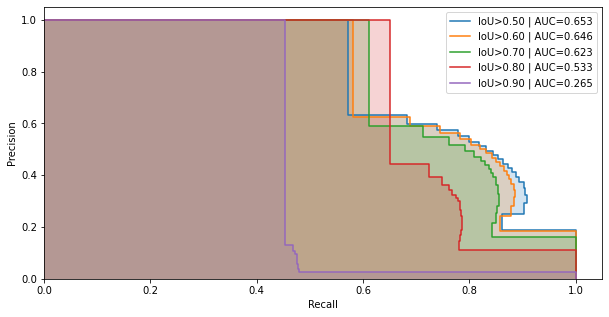

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))

for iou_threshold in torch.arange(start=0.5, end=0.99, step=0.10):
    precision, recall, f1, iou, dist, confidence_thresholds = ev.performance_metrics(iou_threshold=iou_threshold)

    R = torch.cat((torch.ones(1), recall.cpu(), torch.zeros(1)))
    P = torch.cat((torch.zeros(1), precision.cpu(), torch.ones(1)))

    AUC = torch.trapz(R, P)

    ax.fill_between(R, P, alpha=0.2, step='pre')
    ax.step(R, P, label=f'IoU>{iou_threshold:.2f} | AUC={AUC:.3f}')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.05))
ax.set_ylim((0, 1.05))
ax.legend()

In [42]:
# fig.savefig("output/precision_recall_curve.pdf")

In [55]:
_, _, _, _, dist, confidence_thresholds = ev.performance_metrics(iou_threshold=0.5)

Testing:   0%|          | 0/32 [00:00<?, ?it/s, GA_distance=0, IoU=0, f1_score=0, precision=0, recall=0]

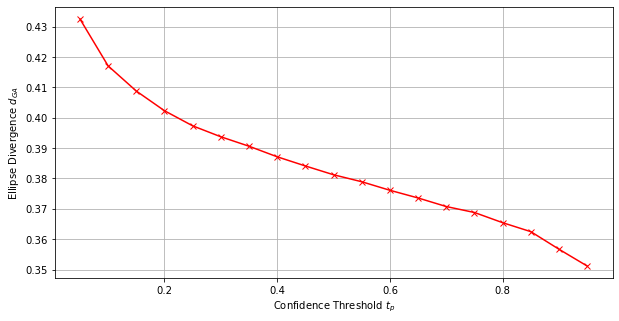

In [58]:
fig2, ax2 = plt.subplots(figsize=(10, 5))

ax2.plot(confidence_thresholds.cpu(), dist.cpu(), 'r-x')
ax2.set_xlabel('Confidence Threshold $t_p$')
ax2.set_ylabel('Ellipse Divergence $d_{GA}$')
ax2.grid()

In [59]:
fig2.savefig('output/confidence_divergence_curve.pdf')

In [1]:
from src.matching import CraterDatabase, CoplanarInvariants
from src.common.data import DataGenerator
from common.conics import plot_conics
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from src.common.conics import *

In [2]:
db = CraterDatabase.from_file(latlims=(0, 30), longlims=(0, 30), diamlims=(5, 25))
generator = DataGenerator.from_robbins_dataset(diamlims=(5, 40))

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa


300.0
300.0
300.0
300.0


array([[  5.35084728,   3.05241575, -17.58491409,   4.63505918,
          2.25627808, -26.05568824,  -5.11019689],
       [  5.35084728,   3.05241575, -17.58491409,   4.63505918,
          2.25627808, -26.05568824,  -5.11019689],
       [  5.35084728,   3.05241575, -17.58491409,   4.63505918,
          2.25627808, -26.05568824,  -5.11019689],
       [  5.35084728,   3.05241575, -17.58491409,   4.63505918,
          2.25627808, -26.05568824,  -5.11019689]])

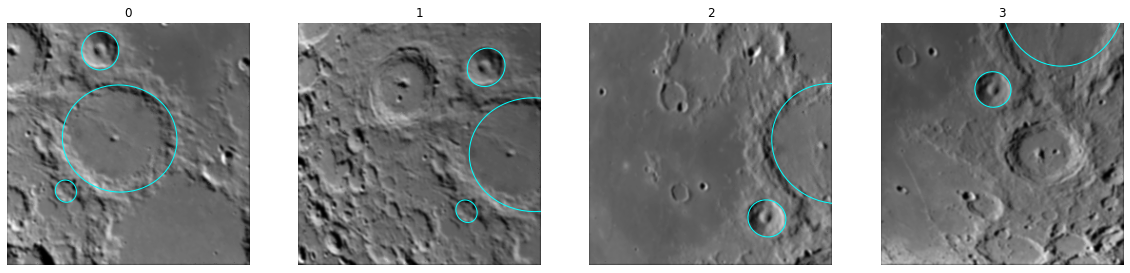

In [190]:
n_rows, n_cols = 1, 4
n_demo = n_rows * n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

k = 0
generator.set_coordinates(
    -12.5,
    -3.5,
    300,
    convert_to_radians=True,
    point_nadir=True
)
generator.scene_time = dt.datetime(2021, 1, 5)
generator.height = 300
C_craters, r_craters = generator.visible_catalogue_craters(None)
a, b = ellipse_axes(C_craters)
C_craters, r_craters = C_craters[a > 20], r_craters[a > 20]
idxs = np.random.choice(np.arange(len(r_craters)), 3)
C_craters, r_craters = C_craters[[5, 6, 8]], r_craters[[5, 6, 8]]

features = np.zeros((n_cols, 7))
for col in range(n_cols):

    generator.point_nadir()
    generator.rotate('roll', np.random.randint(0, 360))
    generator.rotate('pitch', np.random.randint(-30, 30))
    generator.rotate('yaw', np.random.randint(-30, 30))
    # generator.height = 300 + col*100
    print(generator.height)

    A_craters = generator.project_crater_conics(C_craters, r_craters)

    image = generator.generate_image()
    plot_conics(A_craters, ax=axes[col], rim_color='cyan')

    axes[col].imshow(image, cmap='gray')
    axes[col].axis("off")
    axes[col].set_title(k)

    features[col] = CoplanarInvariants.from_detection_conics(A_craters).get_pattern()

    k += 1
features

In [194]:
(features / features).mean(0)

array([1., 1., 1., 1., 1., 1., 1.])

In [219]:
n_test = 5000
sigma_pix = 1
sigma_centre = 1
features_delta = np.zeros((n_test, 7))
for i in range(n_test):
    generator.set_random_position()
    generator.point_nadir()
    generator.rotate('roll', np.random.randint(0, 360))
    generator.rotate('pitch', np.random.randint(-30, 30))
    generator.rotate('yaw', np.random.randint(-30, 30))
    generator.height = np.random.uniform(150, 400)

    A_craters = generator.craters_in_image()
    if len(A_craters) > 3:
        if len(A_craters) > 20:
            idxs = np.random.default_rng().choice(20, 10, replace=False)
            A_craters = A_craters[idxs]
        invariants = CoplanarInvariants.from_detection_conics(A_craters)
        pattern = invariants.get_pattern()
        crater_triads = invariants.crater_triads


        n_det = len(A_craters)
        # Add noise
        major_det, minor_det = ellipse_axes(A_craters)
        psi_det = ellipse_angle(A_craters)
        r_craters_det = conic_center(A_craters)

        major_det += np.random.normal(0, sigma_pix, size=n_det)
        minor_det += np.random.normal(0, sigma_pix, size=n_det)
        psi_det += np.random.uniform(-(10/180)*np.pi, (10/180)*np.pi)
        r_craters_det += np.random.normal(0, sigma_centre, size=r_craters_det.shape)

        A_craters_noisy = conic_matrix(major_det, minor_det, psi_det, *r_craters_det.T)
        A_i, A_j, A_k = np.array(list(map(lambda vertex: A_craters_noisy[vertex], crater_triads.T)))
        pattern_noisy = CoplanarInvariants(crater_triads, A_i, A_j, A_k).get_pattern()

        features_delta[i] = ((pattern - pattern_noisy)/pattern).mean(0)

In [231]:
features_delta[:, 3:6]

array([[-0.11494422, -0.05593432, -0.06511431],
       [-0.09604788,  0.05505322, -0.04283747],
       [-0.03901271, -0.05090826, -0.037605  ],
       ...,
       [ 0.04914522,  0.00370382, -0.07196488],
       [-0.09771442,  0.32467666,  0.00993332],
       [ 0.085208  ,  0.01946386,  0.00438306]])

Text(0.5, 0, '$\\Delta I_{ijk}$')

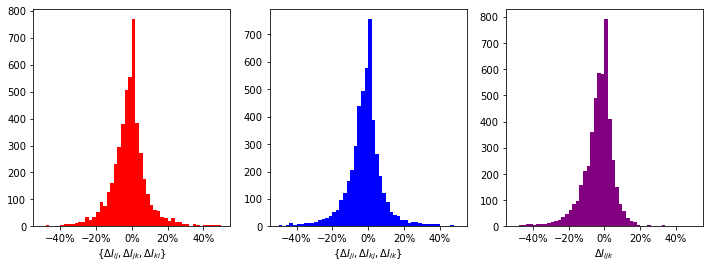

In [248]:
import matplotlib.ticker as mtick
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(features_delta[:, :3].mean(1)*100, range=(-50, 50), bins=50, color='red')
axes[0].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[0].set_xlabel("$\{\Delta I_{ij}, \Delta I_{jk}, \Delta I_{ki}\}$")
axes[1].hist(features_delta[:, 3:6].mean(1)*100, range=(-50, 50), bins=50, color='blue')
axes[1].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[1].set_xlabel("$\{\Delta I_{ji}, \Delta I_{kj}, \Delta I_{ik}\}$")
axes[2].hist(features_delta[:, 6]*100, range=(-50, 50), bins=50, color='purple')
axes[2].xaxis.set_major_formatter(mtick.PercentFormatter())
axes[2].set_xlabel("$\Delta I_{ijk}$")

In [249]:
fig.tight_layout()
# fig.savefig("output/invariants_monte_carlo.pdf")

In [1]:
from src.matching import CraterDatabase, CoplanarInvariants
from src.common.data import DataGenerator
from src.common.conics import *
from src import CraterDetector
import torch

In [2]:
generator = DataGenerator.from_robbins_dataset(diamlims=(5, 40))

cda = CraterDetector()
cda.load_state_dict(torch.load("blobs/CraterRCNN.pth"))
cda.to('cuda')
print()

Surrender Python Client
code revision : c17439eea9ae041bf49364d67a2a232fc89c1faa



In [3]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from tqdm.auto import tqdm as tq
n_demo = 100

test_x_true = np.full((n_demo, 3, 1), np.nan, dtype=np.float64)
test_x_pred = np.full((n_demo, 3, 1), np.nan, dtype=np.float64)
test_attitude = np.zeros((n_demo, 3, 3), dtype=np.float64)
test_sun_angle = np.zeros((n_demo,), dtype=np.float64)
test_n_detections = np.zeros((n_demo,), dtype=np.float64)
test_n_matches = np.zeros((n_demo,), dtype=np.float64)

cda.eval()

for k in tq(range(n_demo)):
    generator.set_coordinates(
        np.random.uniform(10, 20),
        np.random.uniform(10, 20),
        np.random.uniform(350, 400),
        convert_to_radians=True,
        point_nadir=True
    )
    db = CraterDatabase.from_file(latlims=(generator.latitude-5, generator.latitude+5),
                                  longlims=(generator.longitude-5, generator.longitude+5),
                                  diamlims=(5, 25))

    if len(db) < 10:
        continue

    generator.point_nadir()
    generator.rotate('roll', np.random.randint(0, 360))
    generator.rotate('pitch', np.random.randint(-30, 30))
    generator.rotate('yaw', np.random.randint(-30, 30))

    A_craters = generator.craters_in_image()
    image = generator.generate_image()
    image = torch.as_tensor(image[None, None, ...]).to('cuda')
    with torch.no_grad():
        pred = cda(image)[0]

    scores = pred['scores']
    A_detected = pred['ellipse_matrices'][scores > 0.50].cpu().numpy()


    test_x_true[k] = generator.position
    test_attitude[k] = generator.attitude
    test_sun_angle[k] = generator.solar_incidence_angle
    result, n_matches = db.query_position(
        A_detected,
        generator.T,
        generator.K,
        regression_type='ransac',
        return_num_matches=True,
        #kwargs
        top_n=5
    )

    if result is not None:
        print(f"Match [{k}]! Position Error: {LA.norm(result - generator.position):.2f} km | {n_matches} matches")
        test_x_pred[k], test_n_matches[k] = result, n_matches
print("Done")

  0%|          | 0/100 [00:00<?, ?it/s]

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [6]:
generator.longitude

19.006913407801854

In [ ]:
def match_trial_summary(test_x_true,
                        test_x_pred,
                        test_attitude,
                        test_sun_angle,
                        test_n_detections,
                        test_n_matches
                        ):
    pass
